### Problem Definition  


In the second question, we implemented a Neural Network based on bi-directional LSTM for the sentence-level relation classification. Today there are many ways to solve these problems but in this assignment, we used an RNN-based model because it is particularly capable of learning long-distance relation patterns, which makes it suitable for real-world applications where complicated expressions are often involved. SemEval-2010 Task 8 was used as a dataset for this purpose. The data set includes training and test data. The training dataset consists of 8,000 examples, and the testing set consists of 2,717examples, from the nine relations, and for the additional Other relation.

In [ ]:
#Importing required libraries 
import numpy as np 
import pandas as pd 
import os, sys 

import random 
import matplotlib.pyplot as plt
import string

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from tqdm import tqdm 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

### Load the dataset to colab directory 

For the sake of speed, copy the dataset files to the root directory of notebook and unziped them. 

In [ ]:
!cp /content/drive/My\ Drive/SemEval2010_task8_all_data.zip /content/SemEval2010_task8_all_data.zip

In [ ]:
!unzip /content/SemEval2010_task8_all_data.zip

Archive:  /content/SemEval2010_task8_all_data.zip
   creating: SemEval2010_task8_all_data/
   creating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key1.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key2.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key3.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key5.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer1.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer2.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer3.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer4.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer5.txt  
  inflating: SemEval2

### Vocabulary 

In [ ]:
class Vocabulary_and_Dataframe:
    def __init__(self, freq_threshold = 5, pretrained_vocab = None):
        self.freq_threshold = freq_threshold
        
        if pretrained_vocab is None :
            self.frequencies = {}
            self.idx_2_str = {0: "<pad>", 1: "<unk>"}
            self.str_2_idx = {"<pad>": 0, "<unk>": 1}

        else : 
            self.idx_2_str = pretrained_vocab.itos
            self.str_2_idx = pretrained_vocab.stoi
            self.idx_2_str.append("<pad>")
            self.str_2_idx["<pad>"] = len(self.str_2_idx)
            self.idx_2_str.append("<unk>")
            self.str_2_idx["<unk>"] = len(self.str_2_idx)
            self.idx_2_str.append("e1start")
            self.str_2_idx["e1start"] = len(self.str_2_idx) 
            self.idx_2_str.append("e1end")
            self.str_2_idx["e1end"] = len(self.str_2_idx) 
            self.idx_2_str.append("e2start")
            self.str_2_idx["e2start"] = len(self.str_2_idx) 
            self.idx_2_str.append("e2end")
            self.str_2_idx["e2end"] = len(self.str_2_idx)  
            

    def __len__(self):
        return len(self.idx_2_str)

    @staticmethod
    def preprocess(text):
        # tokenize
        text = text.split()
        # convert to lower case
        text = [word.lower() for word in text]
        # remove punctuation from each token
        text = [w.translate(str.maketrans('', '', string.punctuation)) for w in text]

        return text

    def build_vocabulary_and_dataframe(self, text_file_root):

        self.df = pd.DataFrame(columns=('label', 'sentence'))
        
        idx = 2
        lines = [line.strip() for line in open(text_file_root)]
        
        for i in range(0, int(len(lines)/4)):
            #print("**",piece[0][0:5])
            sentence_num = lines[i*4].split("\t")[0]
            sentence = lines[i*4].split("\t")[1][1:-1]
            label = lines[i * 4 + 1] 
            #sentence = piece[0].split('\t')[1].strip('"')
            #print(sentence)
            sentence = sentence.replace("<e1>", " e1start ").replace("</e1>", " e1end ")
            sentence = sentence.replace("<e2>", " e2start ").replace("</e2>", " e2end ")

            #sentence = pattern_repl.sub('', sentence)
            #print("***",sentence)
            words =  self.preprocess(sentence)
            for word in words:
                #print("****",word)
                if word not in self.frequencies:
                    self.frequencies[word] = 1

                else:
                    self.frequencies[word] += 1

                if self.frequencies[word] == self.freq_threshold:
                    self.str_2_idx[word] = idx
                    self.idx_2_str[idx] = word
                    idx += 1

            self.df.loc[i] = [label, " ".join(words)] 
                    #piece = []
        #print(len(self.frequencies))

    def IndexEncoding(self, text):
        tokenized_text = self.preprocess(text)
        index_encoded_text = [self.str_2_idx[token] if token in self.str_2_idx else self.str_2_idx["<unk>"]
                                for token in tokenized_text ]
        
        return index_encoded_text

    def get_str_2_idx(self):
        return self.str_2_idx

    def get_df(self):
        return self.df

In [ ]:
vocab_df = Vocabulary_and_Dataframe(freq_threshold = 5)

train_txt_root = "/content/SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT"
vocab_df.build_vocabulary_and_dataframe(train_txt_root)

train_df = vocab_df.get_df() 

test_txt_root = "/content/SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT"
vocab_df.build_vocabulary_and_dataframe(test_txt_root)

test_df = vocab_df.get_df() 

print(len(vocab_df.get_str_2_idx()))


4815


In [ ]:
train_df

,label,sentence
0,"Component-Whole(e2,e1)",the system as described above has its greatest...
1,Other,the e1start child e1end was carefully wrapped ...
2,"Instrument-Agency(e2,e1)",the e1start author e1end of a keygen uses a e2...
3,Other,a misty e1start ridge e1end uprises from the e...
4,"Member-Collection(e1,e2)",the e1start student e1end e2start association ...
...,...,...
7995,Other,when the e1start notice e1end is sent by e2sta...
7996,"Entity-Origin(e1,e2)",the e1start herbicide e1end is derived from a ...
7997,"Entity-Destination(e1,e2)",to test this we placed a kitchen e1start match...
7998,Other,the farmers and city officials in the region h...


In [ ]:
test_df

,label,sentence
0,"Message-Topic(e1,e2)",the most common e1start audits e1end were abou...
1,"Product-Producer(e2,e1)",the e1start company e1end fabricates plastic e...
2,"Instrument-Agency(e2,e1)",the school e1start master e1end teaches the le...
3,"Entity-Destination(e1,e2)",the suspect dumped the dead e1start body e1end...
4,"Cause-Effect(e2,e1)",avian e1start influenza e1end is an infectious...
...,...,...
2712,"Instrument-Agency(e2,e1)",after seating all the idols which itself takes...
2713,"Product-Producer(e1,e2)",the minister attributed the slow production of...
2714,"Component-Whole(e2,e1)",the e1start umbrella e1end e2start frame e2end...
2715,"Product-Producer(e1,e2)",manos the hands of fate is a lowbudget horror ...


### SemEval2010_task8 Dataset

In [ ]:
class SemEval2010_task8_Dataset(torch.utils.data.Dataset):
    """
    Characterize SemEval2010_task8 Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """
    def __init__(self, df, indices, vocab):
        
        self.df = df
        self.df = self.df.iloc[indices]

        # Get img names, caption columns
        self.sentences = self.df["sentence"].tolist()
        self.labels = self.df["Encoded_Label"].tolist()

        self.vocab = vocab 
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.sentences)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        sentence = self.sentences[index]
        label = self.labels[index]

        tensor_sentence = torch.tensor(self.vocab.IndexEncoding(sentence))

        return tensor_sentence ,torch.tensor(label)


### Split Dataset and Activate CUDA

In [ ]:
#train/val/test split 
random.seed(2045)

train_df['label'] = train_df['label'].astype("category")
train_df["Encoded_Label"] = train_df['label'].cat.codes 

test_df['label'] = test_df['label'].astype("category")
test_df["Encoded_Label"] = test_df['label'].cat.codes 

indices = list(range(7110))
num_samples = len(indices)
random.shuffle(indices)

train_indices = indices[0 : int(0.9 * num_samples)]
validation_indices = indices[int(0.9 * num_samples) : ]
test_indices = test_df.index.values

partition = {'train' : train_indices , 'validation' : validation_indices,
             'test' : test_indices }

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
len(partition['test'])

2717

### padding

In [ ]:
class BatchPadCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):

        sentences = [item[0] for item in batch]
        sentences = pad_sequence(sentences, batch_first=False, padding_value=self.pad_idx)

        labels = torch.tensor( [item[1] for item in batch])

        return sentences, labels

## Part 1: Train Embedding 

### Relation Classification Model

In [ ]:
class RelationClassification_Model(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers,class_num,pad_idx):
        super(RelationClassification_Model, self).__init__()
        
        self.hidden_size = hidden_size
    
        self.embedding = nn.Embedding(vocab_size, embedding_size,padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers,bidirectional = True)
        self.linear = nn.Linear(2*hidden_size, class_num)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.7)

    def forward(self, X):
        embeddings = self.dropout(self.embedding(X))
        hiddens, _ = self.lstm(embeddings)
        x = hiddens.view((hiddens.shape[0], hiddens.shape[1], 2, self.hidden_size))
        concats = torch.cat((x[-1,:,0,:],x[0,:,1,:]), dim = 1)
        outputs = self.softmax(self.linear(concats))

        return outputs 

### Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

int_2_cat_class = dict(enumerate(train_df['label'].cat.categories))

# Training and validation Data Generators
training_set = SemEval2010_task8_Dataset(train_df,partition['train'],vocab_df)

pad_idx = vocab_df.str_2_idx["<pad>"]

# Parameters
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers':0,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  SemEval2010_task8_Dataset(train_df,partition['validation'],vocab_df)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 100
hidden_size = 150
vocab_size = len(vocab_df)
num_layers = 2
class_num = len(int_2_cat_class)
learning_rate = 3e-4
num_epochs = 200

# Model
model = RelationClassification_Model(embedding_size, hidden_size, vocab_size, num_layers,class_num,pad_idx).to(device)

# Define Loss function and Optimizer
criterion = nn.NLLLoss(ignore_index = vocab_df.str_2_idx["<pad>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

dataiter = iter(training_generator)
batch_train_data, batch_train_labels = dataiter.next()

dataiter = iter(validation_generator)
batch_data, batch_labels = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training

    # Transfer to GPU
    batch_train_data, batch_train_labels = batch_train_data.to(device), batch_train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model(batch_train_data)
    # print(batch_train_outputs.shape,"*",batch_train_labels.shape)
    # print(batch_train_outputs,"*",batch_train_labels)
    
    loss = criterion(batch_train_outputs, batch_train_labels)
    # print("**",loss)

    loss.backward()
    optimizer.step()

    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels) 

    if train_cnt % 10 == 9:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):

        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model(batch_data)
        
        val_loss = criterion(batch_outputs, batch_labels)

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)


100%|██████████| 200/200 [00:02<00:00, 90.90it/s]


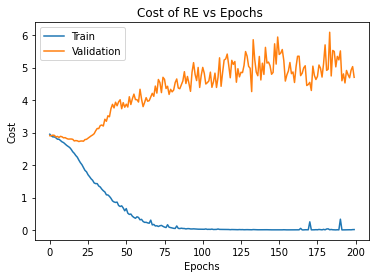

In [ ]:
plot_cost = 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of RE vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()


### Training

In [ ]:
torch.manual_seed(2045)

int_2_cat_class = dict(enumerate(train_df['label'].cat.categories))

# Training and validation Data Generators
training_set = SemEval2010_task8_Dataset(train_df,partition['train'],vocab_df)

pad_idx = vocab_df.str_2_idx["<pad>"]

# Parameters
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  SemEval2010_task8_Dataset(train_df,partition['validation'],vocab_df)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 100
hidden_size = 150
vocab_size = len(vocab_df)
num_layers = 2
class_num = len(int_2_cat_class)
learning_rate = 5e-3
num_epochs = 70

# Model
model = RelationClassification_Model(embedding_size, hidden_size, vocab_size, num_layers,class_num,pad_idx).to(device)

# Define Loss function and Optimizer
criterion = nn.NLLLoss(ignore_index = vocab_df.str_2_idx["<pad>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= 4e-3)
# scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.5)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training
    for batch_train_data, batch_train_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_train_data, batch_train_labels = batch_train_data.to(device), batch_train_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = model(batch_train_data)
        # print(batch_train_outputs.shape,"*",batch_train_labels.shape)
        # print(batch_train_outputs,"*",batch_train_labels)
        
        loss = criterion(batch_train_outputs, batch_train_labels)
        # print("**",loss)

        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels) 

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1

    
    # Validation
    running_loss, val_acc = 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = model(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
        
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

    #scheduler.step()


 40%|████      | 10/25 [00:18<00:27,  1.85s/it]

Cost of Train data after 10 iterations in epoch 1 : 2.729687



 80%|████████  | 20/25 [00:38<00:09,  1.98s/it]

Cost of Train data after 20 iterations in epoch 1 : 2.619400



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:19<00:27,  1.83s/it]

Cost of Train data after 10 iterations in epoch 2 : 2.574421



 80%|████████  | 20/25 [00:39<00:09,  1.94s/it]

Cost of Train data after 20 iterations in epoch 2 : 2.519858



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:20<00:26,  1.74s/it]

Cost of Train data after 10 iterations in epoch 3 : 2.444155



 80%|████████  | 20/25 [00:38<00:08,  1.72s/it]

Cost of Train data after 20 iterations in epoch 3 : 2.400922



100%|██████████| 25/25 [00:49<00:00,  1.97s/it]

 40%|████      | 10/25 [00:20<00:29,  1.97s/it]

Cost of Train data after 10 iterations in epoch 4 : 2.428332



 80%|████████  | 20/25 [00:39<00:09,  1.85s/it]

Cost of Train data after 20 iterations in epoch 4 : 2.381133



100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

 40%|████      | 10/25 [00:17<00:29,  1.98s/it]

Cost of Train data after 10 iterations in epoch 5 : 2.327806



 80%|████████  | 20/25 [00:37<00:09,  1.90s/it]

Cost of Train data after 20 iterations in epoch 5 : 2.267686



100%|██████████| 25/25 [00:47<00:00,  1.92s/it]

 40%|████      | 10/25 [00:20<00:29,  1.98s/it]

Cost of Train data after 10 iterations in epoch 6 : 2.212449



 80%|████████  | 20/25 [00:39<00:09,  1.95s/it]

Cost of Train data after 20 iterations in epoch 6 : 2.177653



100%|██████████| 25/25 [00:47<00:00,  1.90s/it]

 40%|████      | 10/25 [00:18<00:29,  1.94s/it]

Cost of Train data after 10 iterations in epoch 7 : 2.110725



 80%|████████  | 20/25 [00:38<00:10,  2.05s/it]

Cost of Train data after 20 iterations in epoch 7 : 2.073034



100%|██████████| 25/25 [00:47<00:00,  1.89s/it]

 40%|████      | 10/25 [00:18<00:28,  1.92s/it]

Cost of Train data after 10 iterations in epoch 8 : 1.980228



 80%|████████  | 20/25 [00:38<00:10,  2.05s/it]

Cost of Train data after 20 iterations in epoch 8 : 1.932077



100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

 40%|████      | 10/25 [00:19<00:27,  1.85s/it]

Cost of Train data after 10 iterations in epoch 9 : 1.880557



 80%|████████  | 20/25 [00:39<00:11,  2.20s/it]

Cost of Train data after 20 iterations in epoch 9 : 1.829697



100%|██████████| 25/25 [00:46<00:00,  1.87s/it]

 40%|████      | 10/25 [00:18<00:28,  1.87s/it]

Cost of Train data after 10 iterations in epoch 10 : 1.843250



 80%|████████  | 20/25 [00:36<00:09,  1.81s/it]

Cost of Train data after 20 iterations in epoch 10 : 1.790375



100%|██████████| 25/25 [00:46<00:00,  1.85s/it]

 40%|████      | 10/25 [00:18<00:25,  1.69s/it]

Cost of Train data after 10 iterations in epoch 11 : 1.804830



 80%|████████  | 20/25 [00:37<00:09,  1.96s/it]

Cost of Train data after 20 iterations in epoch 11 : 1.752897



100%|██████████| 25/25 [00:48<00:00,  1.92s/it]

 40%|████      | 10/25 [00:18<00:26,  1.77s/it]

Cost of Train data after 10 iterations in epoch 12 : 1.729421



 80%|████████  | 20/25 [00:38<00:09,  1.82s/it]

Cost of Train data after 20 iterations in epoch 12 : 1.718951



100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

 40%|████      | 10/25 [00:20<00:30,  2.03s/it]

Cost of Train data after 10 iterations in epoch 13 : 1.737420



 80%|████████  | 20/25 [00:40<00:09,  1.90s/it]

Cost of Train data after 20 iterations in epoch 13 : 1.691450



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:20<00:33,  2.23s/it]

Cost of Train data after 10 iterations in epoch 14 : 1.640672



 80%|████████  | 20/25 [00:39<00:09,  1.96s/it]

Cost of Train data after 20 iterations in epoch 14 : 1.701116



100%|██████████| 25/25 [00:47<00:00,  1.91s/it]

 40%|████      | 10/25 [00:19<00:30,  2.04s/it]

Cost of Train data after 10 iterations in epoch 15 : 1.653183



 80%|████████  | 20/25 [00:38<00:10,  2.06s/it]

Cost of Train data after 20 iterations in epoch 15 : 1.657317



100%|██████████| 25/25 [00:46<00:00,  1.86s/it]

 40%|████      | 10/25 [00:18<00:25,  1.71s/it]

Cost of Train data after 10 iterations in epoch 16 : 1.590572



 80%|████████  | 20/25 [00:36<00:09,  1.82s/it]

Cost of Train data after 20 iterations in epoch 16 : 1.609044



100%|██████████| 25/25 [00:46<00:00,  1.87s/it]

 40%|████      | 10/25 [00:17<00:24,  1.64s/it]

Cost of Train data after 10 iterations in epoch 17 : 1.581143



 80%|████████  | 20/25 [00:37<00:11,  2.30s/it]

Cost of Train data after 20 iterations in epoch 17 : 1.629177



100%|██████████| 25/25 [00:46<00:00,  1.87s/it]

 40%|████      | 10/25 [00:20<00:29,  1.94s/it]

Cost of Train data after 10 iterations in epoch 18 : 1.573988



 80%|████████  | 20/25 [00:39<00:09,  1.96s/it]

Cost of Train data after 20 iterations in epoch 18 : 1.552357



100%|██████████| 25/25 [00:47<00:00,  1.90s/it]

 40%|████      | 10/25 [00:20<00:29,  1.95s/it]

Cost of Train data after 10 iterations in epoch 19 : 1.520345



 80%|████████  | 20/25 [00:38<00:09,  1.82s/it]

Cost of Train data after 20 iterations in epoch 19 : 1.557386



100%|██████████| 25/25 [00:48<00:00,  1.94s/it]

 40%|████      | 10/25 [00:19<00:25,  1.70s/it]

Cost of Train data after 10 iterations in epoch 20 : 1.548404



 80%|████████  | 20/25 [00:38<00:09,  1.80s/it]

Cost of Train data after 20 iterations in epoch 20 : 1.521453



100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

 40%|████      | 10/25 [00:18<00:28,  1.90s/it]

Cost of Train data after 10 iterations in epoch 21 : 1.515051



 80%|████████  | 20/25 [00:38<00:10,  2.02s/it]

Cost of Train data after 20 iterations in epoch 21 : 1.524205



100%|██████████| 25/25 [00:46<00:00,  1.86s/it]

 40%|████      | 10/25 [00:20<00:29,  1.98s/it]

Cost of Train data after 10 iterations in epoch 22 : 1.477432



 80%|████████  | 20/25 [00:38<00:08,  1.76s/it]

Cost of Train data after 20 iterations in epoch 22 : 1.458639



100%|██████████| 25/25 [00:48<00:00,  1.92s/it]

 40%|████      | 10/25 [00:20<00:30,  2.04s/it]

Cost of Train data after 10 iterations in epoch 23 : 1.416662



 80%|████████  | 20/25 [00:38<00:09,  1.85s/it]

Cost of Train data after 20 iterations in epoch 23 : 1.458957



100%|██████████| 25/25 [00:47<00:00,  1.88s/it]

 40%|████      | 10/25 [00:19<00:25,  1.71s/it]

Cost of Train data after 10 iterations in epoch 24 : 1.429808



 80%|████████  | 20/25 [00:39<00:09,  1.90s/it]

Cost of Train data after 20 iterations in epoch 24 : 1.417656



100%|██████████| 25/25 [00:48<00:00,  1.94s/it]

 40%|████      | 10/25 [00:18<00:29,  1.95s/it]

Cost of Train data after 10 iterations in epoch 25 : 1.437339



 80%|████████  | 20/25 [00:38<00:10,  2.11s/it]

Cost of Train data after 20 iterations in epoch 25 : 1.402023



100%|██████████| 25/25 [00:47<00:00,  1.89s/it]

 40%|████      | 10/25 [00:18<00:25,  1.68s/it]

Cost of Train data after 10 iterations in epoch 26 : 1.425542



 80%|████████  | 20/25 [00:39<00:09,  1.92s/it]

Cost of Train data after 20 iterations in epoch 26 : 1.397623



100%|██████████| 25/25 [00:48<00:00,  1.96s/it]

 40%|████      | 10/25 [00:19<00:29,  1.97s/it]

Cost of Train data after 10 iterations in epoch 27 : 1.367773



 80%|████████  | 20/25 [00:39<00:08,  1.70s/it]

Cost of Train data after 20 iterations in epoch 27 : 1.412054



100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

 40%|████      | 10/25 [00:19<00:27,  1.82s/it]

Cost of Train data after 10 iterations in epoch 28 : 1.352885



 80%|████████  | 20/25 [00:39<00:10,  2.10s/it]

Cost of Train data after 20 iterations in epoch 28 : 1.349549



100%|██████████| 25/25 [00:49<00:00,  1.96s/it]

 40%|████      | 10/25 [00:18<00:27,  1.86s/it]

Cost of Train data after 10 iterations in epoch 29 : 1.328325



 80%|████████  | 20/25 [00:39<00:09,  1.94s/it]

Cost of Train data after 20 iterations in epoch 29 : 1.340928



100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

 40%|████      | 10/25 [00:19<00:26,  1.77s/it]

Cost of Train data after 10 iterations in epoch 30 : 1.333673



 80%|████████  | 20/25 [00:36<00:09,  1.90s/it]

Cost of Train data after 20 iterations in epoch 30 : 1.319336



100%|██████████| 25/25 [00:48<00:00,  1.92s/it]

 40%|████      | 10/25 [00:19<00:29,  1.96s/it]

Cost of Train data after 10 iterations in epoch 31 : 1.281607



 80%|████████  | 20/25 [00:39<00:08,  1.78s/it]

Cost of Train data after 20 iterations in epoch 31 : 1.284477



100%|██████████| 25/25 [00:47<00:00,  1.92s/it]

 40%|████      | 10/25 [00:19<00:30,  2.02s/it]

Cost of Train data after 10 iterations in epoch 32 : 1.281872



 80%|████████  | 20/25 [00:38<00:09,  1.91s/it]

Cost of Train data after 20 iterations in epoch 32 : 1.310415



100%|██████████| 25/25 [00:48<00:00,  1.94s/it]

 40%|████      | 10/25 [00:20<00:29,  1.97s/it]

Cost of Train data after 10 iterations in epoch 33 : 1.282542



 80%|████████  | 20/25 [00:39<00:10,  2.02s/it]

Cost of Train data after 20 iterations in epoch 33 : 1.277080



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:21<00:29,  1.97s/it]

Cost of Train data after 10 iterations in epoch 34 : 1.299836



 80%|████████  | 20/25 [00:40<00:09,  1.92s/it]

Cost of Train data after 20 iterations in epoch 34 : 1.294818



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:20<00:29,  2.00s/it]

Cost of Train data after 10 iterations in epoch 35 : 1.285858



 80%|████████  | 20/25 [00:39<00:09,  1.98s/it]

Cost of Train data after 20 iterations in epoch 35 : 1.281394



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:18<00:28,  1.92s/it]

Cost of Train data after 10 iterations in epoch 36 : 1.262290



 80%|████████  | 20/25 [00:38<00:10,  2.00s/it]

Cost of Train data after 20 iterations in epoch 36 : 1.221986



100%|██████████| 25/25 [00:46<00:00,  1.84s/it]

 40%|████      | 10/25 [00:20<00:29,  1.96s/it]

Cost of Train data after 10 iterations in epoch 37 : 1.293270



 80%|████████  | 20/25 [00:37<00:08,  1.64s/it]

Cost of Train data after 20 iterations in epoch 37 : 1.246878



100%|██████████| 25/25 [00:46<00:00,  1.87s/it]

 40%|████      | 10/25 [00:19<00:29,  1.97s/it]

Cost of Train data after 10 iterations in epoch 38 : 1.201297



 80%|████████  | 20/25 [00:37<00:08,  1.74s/it]

Cost of Train data after 20 iterations in epoch 38 : 1.218971



100%|██████████| 25/25 [00:46<00:00,  1.87s/it]

 40%|████      | 10/25 [00:19<00:28,  1.92s/it]

Cost of Train data after 10 iterations in epoch 39 : 1.198552



 80%|████████  | 20/25 [00:39<00:09,  1.92s/it]

Cost of Train data after 20 iterations in epoch 39 : 1.232198



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:21<00:27,  1.84s/it]

Cost of Train data after 10 iterations in epoch 40 : 1.204454



 80%|████████  | 20/25 [00:39<00:09,  1.94s/it]

Cost of Train data after 20 iterations in epoch 40 : 1.226548



100%|██████████| 25/25 [00:48<00:00,  1.94s/it]

 40%|████      | 10/25 [00:19<00:29,  1.94s/it]

Cost of Train data after 10 iterations in epoch 41 : 1.183904



 80%|████████  | 20/25 [00:37<00:08,  1.72s/it]

Cost of Train data after 20 iterations in epoch 41 : 1.242593



100%|██████████| 25/25 [00:47<00:00,  1.92s/it]

 40%|████      | 10/25 [00:19<00:27,  1.86s/it]

Cost of Train data after 10 iterations in epoch 42 : 1.168625



 80%|████████  | 20/25 [00:38<00:09,  2.00s/it]

Cost of Train data after 20 iterations in epoch 42 : 1.246950



100%|██████████| 25/25 [00:49<00:00,  1.96s/it]

 40%|████      | 10/25 [00:21<00:33,  2.21s/it]

Cost of Train data after 10 iterations in epoch 43 : 1.206493



 80%|████████  | 20/25 [00:40<00:09,  1.84s/it]

Cost of Train data after 20 iterations in epoch 43 : 1.225502



100%|██████████| 25/25 [00:49<00:00,  2.00s/it]

 40%|████      | 10/25 [00:21<00:32,  2.18s/it]

Cost of Train data after 10 iterations in epoch 44 : 1.160296



 80%|████████  | 20/25 [00:39<00:08,  1.79s/it]

Cost of Train data after 20 iterations in epoch 44 : 1.203119



100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

 40%|████      | 10/25 [00:20<00:31,  2.07s/it]

Cost of Train data after 10 iterations in epoch 45 : 1.180992



 80%|████████  | 20/25 [00:40<00:10,  2.05s/it]

Cost of Train data after 20 iterations in epoch 45 : 1.211006



100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

 40%|████      | 10/25 [00:20<00:30,  2.03s/it]

Cost of Train data after 10 iterations in epoch 46 : 1.196977



 80%|████████  | 20/25 [00:38<00:08,  1.78s/it]

Cost of Train data after 20 iterations in epoch 46 : 1.214900



100%|██████████| 25/25 [00:48<00:00,  1.94s/it]

 40%|████      | 10/25 [00:22<00:31,  2.11s/it]

Cost of Train data after 10 iterations in epoch 47 : 1.185754



 80%|████████  | 20/25 [00:39<00:08,  1.77s/it]

Cost of Train data after 20 iterations in epoch 47 : 1.170515



100%|██████████| 25/25 [00:49<00:00,  1.96s/it]

 40%|████      | 10/25 [00:19<00:28,  1.93s/it]

Cost of Train data after 10 iterations in epoch 48 : 1.140441



 80%|████████  | 20/25 [00:38<00:09,  1.83s/it]

Cost of Train data after 20 iterations in epoch 48 : 1.218777



100%|██████████| 25/25 [00:47<00:00,  1.91s/it]

 40%|████      | 10/25 [00:18<00:26,  1.74s/it]

Cost of Train data after 10 iterations in epoch 49 : 1.127683



 80%|████████  | 20/25 [00:38<00:09,  1.81s/it]

Cost of Train data after 20 iterations in epoch 49 : 1.182127



100%|██████████| 25/25 [00:48<00:00,  1.94s/it]

 40%|████      | 10/25 [00:21<00:34,  2.28s/it]

Cost of Train data after 10 iterations in epoch 50 : 1.143954



 80%|████████  | 20/25 [00:40<00:08,  1.79s/it]

Cost of Train data after 20 iterations in epoch 50 : 1.143520



100%|██████████| 25/25 [00:49<00:00,  1.99s/it]

 40%|████      | 10/25 [00:20<00:30,  2.02s/it]

Cost of Train data after 10 iterations in epoch 51 : 1.120657



 80%|████████  | 20/25 [00:38<00:09,  1.81s/it]

Cost of Train data after 20 iterations in epoch 51 : 1.153440



100%|██████████| 25/25 [00:49<00:00,  2.00s/it]

 40%|████      | 10/25 [00:17<00:24,  1.61s/it]

Cost of Train data after 10 iterations in epoch 52 : 1.152878



 72%|███████▏  | 18/25 [00:33<00:12,  1.81s/it]


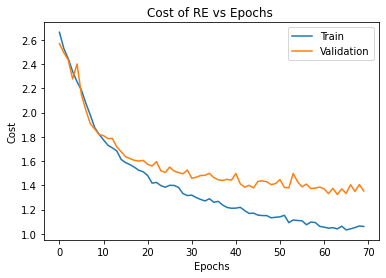

In [ ]:
plt.plot(train_losses)
plt.plot(validation_losses)
plt.title("Cost of RE vs Epochs ")
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

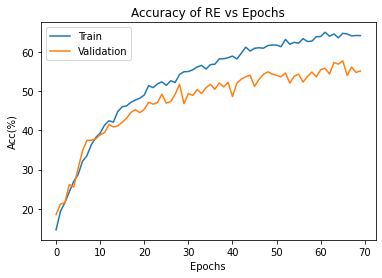

In [ ]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.title("Accuracy of RE vs Epochs")
plt.ylabel('Acc(%)')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

In [ ]:
PATH = '/content/drive/My Drive/RelationClassification.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
print(train_losses)

[2.6626903343200685, 2.52872989654541, 2.4444201469421385, 2.3394992637634275, 2.253653326034546, 2.1845245456695555, 2.0764102029800413, 1.9804178714752196, 1.8763989877700806, 1.821306209564209, 1.7745400476455688, 1.730615634918213, 1.7087364292144775, 1.684128894805908, 1.613448853492737, 1.5871499586105347, 1.571152276992798, 1.5493851804733276, 1.523909673690796, 1.5117356014251708, 1.4813992357254029, 1.4184301090240479, 1.4238572597503663, 1.3976639461517335, 1.3844682550430298, 1.400239772796631, 1.3991158771514893, 1.3831003761291505, 1.3321803760528566, 1.3154439210891724, 1.3193574523925782, 1.2992173147201538, 1.2840190267562865, 1.2709861040115356, 1.2895569515228271, 1.2601500368118286, 1.2678251314163207, 1.2375550842285157, 1.2175217437744141, 1.210928750038147, 1.2119949293136596, 1.2185527324676513, 1.1913756847381591, 1.168220386505127, 1.1706373405456543, 1.1545121479034424, 1.1506744241714477, 1.1503124856948852, 1.1320894050598145, 1.1367370891571045, 1.139976625

In [ ]:
print(validation_losses)

[2.5687827269236245, 2.4937592347462973, 2.4340335528055825, 2.2773218154907227, 2.4008564949035645, 2.1448148091634116, 2.0200342337290444, 1.9087180693944295, 1.8642277320226033, 1.8191895484924316, 1.8097757895787556, 1.78553307056427, 1.7862923542658489, 1.7179222106933594, 1.6772671937942505, 1.6352555354436238, 1.6205629507700603, 1.6058813730875652, 1.6002813180287678, 1.6057854890823364, 1.5730852683385212, 1.559788743654887, 1.5954039891560872, 1.5202735662460327, 1.50639009475708, 1.5505435069402058, 1.517827033996582, 1.5053842465082805, 1.4952032963434856, 1.525973637898763, 1.4587232271830242, 1.4668164253234863, 1.4807569980621338, 1.4827797412872314, 1.4988176027933757, 1.4641879399617512, 1.4457172950108845, 1.440362771352132, 1.4494798580805461, 1.4430203040440877, 1.4982112248738606, 1.4124425649642944, 1.3846489191055298, 1.4001996119817097, 1.3787209590276082, 1.433064063390096, 1.4366945028305054, 1.4291820526123047, 1.4058126211166382, 1.414721926053365, 1.4472128

In [ ]:
print(train_accs)

[tensor(14.6273, device='cuda:0'), tensor(19.3477, device='cuda:0'), tensor(21.5508, device='cuda:0'), tensor(24.3011, device='cuda:0'), tensor(26.9575, device='cuda:0'), tensor(28.7074, device='cuda:0'), tensor(32.1147, device='cuda:0'), tensor(33.5363, device='cuda:0'), tensor(36.3180, device='cuda:0'), tensor(38.1464, device='cuda:0'), tensor(39.2879, device='cuda:0'), tensor(41.3187, device='cuda:0'), tensor(42.4133, device='cuda:0'), tensor(42.0694, device='cuda:0'), tensor(44.8041, device='cuda:0'), tensor(45.9762, device='cuda:0'), tensor(46.2257, device='cuda:0'), tensor(47.1324, device='cuda:0'), tensor(47.7111, device='cuda:0'), tensor(48.1800, device='cuda:0'), tensor(48.9770, device='cuda:0'), tensor(51.3827, device='cuda:0'), tensor(50.8517, device='cuda:0'), tensor(51.8050, device='cuda:0'), tensor(52.3360, device='cuda:0'), tensor(51.4455, device='cuda:0'), tensor(52.6018, device='cuda:0'), tensor(52.1650, device='cuda:0'), tensor(54.2261, device='cuda:0'), tensor(54.898

In [ ]:
print(val_accs)

[tensor(18.5118, device='cuda:0'), tensor(21.2096, device='cuda:0'), tensor(21.5433, device='cuda:0'), tensor(26.1765, device='cuda:0'), tensor(25.5261, device='cuda:0'), tensor(30.3071, device='cuda:0'), tensor(34.7349, device='cuda:0'), tensor(37.4326, device='cuda:0'), tensor(37.4699, device='cuda:0'), tensor(37.8232, device='cuda:0'), tensor(38.8656, device='cuda:0'), tensor(39.4047, device='cuda:0'), tensor(41.4691, device='cuda:0'), tensor(40.8560, device='cuda:0'), tensor(41.1341, device='cuda:0'), tensor(42.0848, device='cuda:0'), tensor(43.0885, device='cuda:0'), tensor(44.5764, device='cuda:0'), tensor(45.2458, device='cuda:0'), tensor(44.4841, device='cuda:0'), tensor(45.3400, device='cuda:0'), tensor(47.1439, device='cuda:0'), tensor(46.6421, device='cuda:0'), tensor(47.0890, device='cuda:0'), tensor(49.1906, device='cuda:0'), tensor(46.9018, device='cuda:0'), tensor(47.3311, device='cuda:0'), tensor(49.1546, device='cuda:0'), tensor(51.7025, device='cuda:0'), tensor(46.753

### Test Network

In [ ]:
int_2_cat_class = dict(enumerate(train_df['label'].cat.categories))
# Hyperparameters
embedding_size = 100
hidden_size = 150
vocab_size = len(vocab_df)
num_layers = 2
class_num = len(int_2_cat_class)

int_2_cat_class = dict(enumerate(test_df['label'].cat.categories))

# Training and validation Data Generators
test_set = SemEval2010_task8_Dataset(test_df,partition['test'],vocab_df)

pad_idx = vocab_df.str_2_idx["<pad>"]

# Parameters
params = {'batch_size': 2717,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

test_generator = torch.utils.data.DataLoader(test_set, **params)

PATH = '/content/drive/My Drive/RelationClassification.pth'

# Model
model = RelationClassification_Model(embedding_size, hidden_size, vocab_size, num_layers,class_num,pad_idx).to(device)
model.load_state_dict(torch.load(PATH))

with torch.set_grad_enabled(False):
    for batch_data, batch_labels in tqdm(test_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model(batch_data)        

        y_predictions = np.argmax(batch_outputs.cpu().numpy(),axis = 1)
        y_test  = batch_labels.cpu().numpy()

        precision_metric = precision_score(y_test, y_predictions, average = "macro")

        recall_metric = recall_score(y_test, y_predictions, average = "macro")

        accuracy_metric = accuracy_score(y_test, y_predictions)

        f1_metric = f1_score(y_test, y_predictions, average = "macro")



  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


In [ ]:
precision_metric,recall_metric,accuracy_metric ,f1_metric 

(0.438740318271017, 0.4766922089699622, 0.5679057784320942, 0.4506753097954079)

## Part2 : Using GloVe

### Download Pre-trained Embedding 

In [ ]:
from torchtext.vocab import GloVe
glove = GloVe(name='42B', dim=300)


.vector_cache/glove.42B.300d.zip: 0.00B [00:00, ?B/s]
.vector_cache/glove.42B.300d.zip:   0%|          | 8.19k/1.88G [00:00<40:38:33, 12.8kB/s]
.vector_cache/glove.42B.300d.zip:   0%|          | 49.2k/1.88G [00:00<29:00:22, 18.0kB/s]
.vector_cache/glove.42B.300d.zip:   0%|          | 221k/1.88G [00:00<20:26:08, 25.5kB/s] 
.vector_cache/glove.42B.300d.zip:   0%|          | 860k/1.88G [00:01<14:20:08, 36.4kB/s]
.vector_cache/glove.42B.300d.zip:   0%|          | 3.49M/1.88G [00:01<10:01:46, 51.9kB/s]
.vector_cache/glove.42B.300d.zip:   0%|          | 8.59M/1.88G [00:01<7:00:16, 74.1kB/s] 
.vector_cache/glove.42B.300d.zip:   1%|          | 12.0M/1.88G [00:01<4:53:59, 106kB/s] 
.vector_cache/glove.42B.300d.zip:   1%|          | 17.0M/1.88G [00:01<3:25:25, 151kB/s]
.vector_cache/glove.42B.300d.zip:   1%|          | 21.0M/1.88G [00:01<2:23:45, 215kB/s]
.vector_cache/glove.42B.300d.zip:   1%|▏         | 25.2M/1.88G [00:01<1:40:37, 307kB/s]
.vector_cache/glove.42B.300d.zip:   2%|▏         | 28

### Save Pre-trained Embedding 

In [ ]:
vocabulary =  Vocabulary_and_Dataframe(pretrained_vocab = glove)

In [ ]:
torch.save(vocabulary,'/content/drive/My Drive/vocabulary.pt')

In [ ]:
m = torch.mean(glove.vectors,dim = 0, keepdims = True)

In [ ]:
embedding = torch.cat((glove.vectors,m,m,m,m,m,m),dim = 0)

In [ ]:
torch.save(embedding,'/content/drive/My Drive/embedding.pt')

In [ ]:
print(len(glove.stoi))

1917500


In [ ]:
glove.vectors.shape,embedding.shape

(torch.Size([1917494, 300]), torch.Size([1917500, 300]))

### Load Pre-trained Embedding 

In [ ]:
pad_idx = 1917494

In [ ]:
vocab = torch.load('/content/drive/My Drive/vocabulary.pt')

In [ ]:
embedding = torch.load('/content/drive/My Drive/embedding.pt')

In [ ]:
embedding.shape

torch.Size([1917500, 300])

### Relation Classification Model

In [ ]:
class RelationClassification_Model2(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers,class_num,pretrained_embedding,pad_idx):
        super(RelationClassification_Model2, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding =  nn.Embedding.from_pretrained(pretrained_embedding,freeze = True,padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers,bidirectional = True)
        self.linear = nn.Linear(2*hidden_size, class_num)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.7)

    def forward(self, X):
        embeddings = self.dropout(self.embedding(X))
        hiddens, _ = self.lstm(embeddings)
        x = hiddens.view((hiddens.shape[0], hiddens.shape[1], 2, self.hidden_size))
        concats = torch.cat((x[-1,:,0,:],x[0,:,1,:]), dim = 1)
        outputs = self.softmax(self.linear(concats))

        return outputs 

### training...

In [ ]:
torch.manual_seed(2045)

int_2_cat_class = dict(enumerate(train_df['label'].cat.categories))

# Training and validation Data Generators
training_set = SemEval2010_task8_Dataset(train_df,partition['train'],vocab)

# Parameters
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  SemEval2010_task8_Dataset(train_df,partition['validation'],vocab)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 150
vocab_size = len(vocab_df)
num_layers = 2
class_num = len(int_2_cat_class)
learning_rate = 5e-3
num_epochs = 25

# Model
model2 = RelationClassification_Model2(embedding_size, hidden_size, vocab_size, num_layers,class_num, embedding,pad_idx).to(device)

# Define Loss function and Optimizer
criterion = nn.NLLLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model2.parameters(), lr = learning_rate, weight_decay= 5e-4)
# scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.5)

train_losses2 = []
validation_losses2 = []

train_accs2 = []
val_accs2 = []

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training
    for batch_train_data, batch_train_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_train_data, batch_train_labels = batch_train_data.to(device), batch_train_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = model2(batch_train_data)
        # print(batch_train_outputs.shape,"*",batch_train_labels.shape)
        # print(batch_train_outputs,"*",batch_train_labels)
        
        loss = criterion(batch_train_outputs, batch_train_labels)
        # print("**",loss)

        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels) 

        if train_cnt % 50 == 49:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 50))
            running_loss = 0.0
        
        train_cnt += 1

    
    # Validation
    running_loss, val_acc = 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = model2(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
        
    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)

    #scheduler.step()



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:06,  3.67it/s]

  8%|▊         | 2/25 [00:00<00:05,  4.44it/s]

 12%|█▏        | 3/25 [00:00<00:04,  4.94it/s]

 20%|██        | 5/25 [00:00<00:03,  6.04it/s]

 24%|██▍       | 6/25 [00:00<00:02,  6.67it/s]

 28%|██▊       | 7/25 [00:00<00:02,  7.26it/s]

 32%|███▏      | 8/25 [00:01<00:02,  7.42it/s]

 40%|████      | 10/25 [00:01<00:01,  8.21it/s]

 48%|████▊     | 12/25 [00:01<00:01,  8.96it/s]

 56%|█████▌    | 14/25 [00:01<00:01,  9.40it/s]

 64%|██████▍   | 16/25 [00:01<00:00, 10.09it/s]

 72%|███████▏  | 18/25 [00:01<00:00, 10.18it/s]

 80%|████████  | 20/25 [00:02<00:00, 10.36it/s]

 88%|████████▊ | 22/25 [00:02<00:00, 10.53it/s]

100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  8.34it/s]

  4%|▍         | 1/25 [00:03<01:13,  3.06s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         |

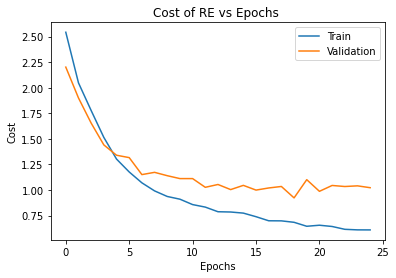

In [ ]:
plt.plot(train_losses2)
plt.plot(validation_losses2)
plt.title("Cost of RE vs Epochs ")
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

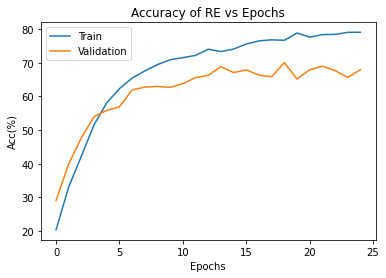

In [ ]:
plt.plot(train_accs2)
plt.plot(val_accs2)
plt.title("Accuracy of RE vs Epochs")
plt.ylabel('Acc(%)')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

In [ ]:
PATH = '/content/drive/My Drive/RelationClassification2.pth'
torch.save(model2.state_dict(), PATH)

In [ ]:
print(train_losses2)

[2.542475519180298, 2.047986569404602, 1.7773819589614868, 1.5146153783798217, 1.3030727052688598, 1.176915020942688, 1.0707797932624816, 0.9919730925559997, 0.9374889278411865, 0.9108690595626832, 0.8581338477134705, 0.8335553407669067, 0.7882645440101623, 0.7856158256530762, 0.7748164463043213, 0.739774944782257, 0.6999326252937317, 0.6990784645080567, 0.6849734830856323, 0.6462079119682312, 0.6564458584785462, 0.6441432499885559, 0.6164913082122803, 0.611071925163269, 0.6105843949317932]


In [ ]:
print(validation_losses2)

[2.2016724745432534, 1.9004280964533489, 1.6545780499776204, 1.4414637088775635, 1.3404428958892822, 1.3171746333440144, 1.1511975526809692, 1.1732559204101562, 1.1405126651128132, 1.11213223139445, 1.1121783057848613, 1.0270015199979146, 1.0545917948087056, 1.0047114690144856, 1.0460035006205242, 0.9998188018798828, 1.0205398003260295, 1.0351913173993428, 0.9235561688741049, 1.1016411383946736, 0.9877827167510986, 1.0450300772984822, 1.0347624619801838, 1.0412604808807373, 1.023171842098236]


In [ ]:
print(train_accs2)

[tensor(20.3335, device='cuda:0'), tensor(33.0996, device='cuda:0'), tensor(42.2732, device='cuda:0'), tensor(51.5869, device='cuda:0'), tensor(58.0871, device='cuda:0'), tensor(62.2915, device='cuda:0'), tensor(65.4164, device='cuda:0'), tensor(67.5575, device='cuda:0'), tensor(69.4328, device='cuda:0'), tensor(70.8706, device='cuda:0'), tensor(71.4958, device='cuda:0'), tensor(72.1670, device='cuda:0'), tensor(74.0123, device='cuda:0'), tensor(73.3091, device='cuda:0'), tensor(74.0434, device='cuda:0'), tensor(75.5431, device='cuda:0'), tensor(76.4809, device='cuda:0'), tensor(76.7933, device='cuda:0'), tensor(76.6520, device='cuda:0'), tensor(78.8092, device='cuda:0'), tensor(77.5903, device='cuda:0'), tensor(78.3399, device='cuda:0'), tensor(78.4031, device='cuda:0'), tensor(79.0124, device='cuda:0'), tensor(79.0434, device='cuda:0')]


In [ ]:
print(val_accs2)

[tensor(29.0980, device='cuda:0'), tensor(39.9439, device='cuda:0'), tensor(47.7210, device='cuda:0'), tensor(53.9913, device='cuda:0'), tensor(55.8319, device='cuda:0'), tensor(56.8932, device='cuda:0'), tensor(61.9170, device='cuda:0'), tensor(62.7532, device='cuda:0'), tensor(62.9574, device='cuda:0'), tensor(62.6603, device='cuda:0'), tensor(63.7759, device='cuda:0'), tensor(65.5628, device='cuda:0'), tensor(66.2329, device='cuda:0'), tensor(68.8370, device='cuda:0'), tensor(67.0697, device='cuda:0'), tensor(67.8510, device='cuda:0'), tensor(66.3074, device='cuda:0'), tensor(65.8220, device='cuda:0'), tensor(70.0285, device='cuda:0'), tensor(65.1532, device='cuda:0'), tensor(67.9066, device='cuda:0'), tensor(68.9672, device='cuda:0'), tensor(67.6468, device='cuda:0'), tensor(65.6374, device='cuda:0'), tensor(67.9256, device='cuda:0')]


### Test Network

In [ ]:
int_2_cat_class = dict(enumerate(train_df['label'].cat.categories))

# Hyperparameters
embedding_size = 300
hidden_size = 150
vocab_size = len(vocab_df)
num_layers = 2
class_num = len(int_2_cat_class)

int_2_cat_class = dict(enumerate(test_df['label'].cat.categories))

# Training and validation Data Generators
test_set = SemEval2010_task8_Dataset(test_df,partition['test'],vocab)

pad_idx = vocab_df.str_2_idx["<pad>"]

# Parameters
params = {'batch_size': 2717,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

test_generator = torch.utils.data.DataLoader(test_set, **params)

# PATH = '/content/drive/My Drive/RelationClassification2.pth'

# # Model
# model2 = RelationClassification_Model2(embedding_size, hidden_size, vocab_size, num_layers,class_num,embedding,pad_idx).to(device)
# model2.load_state_dict(torch.load(PATH))

with torch.set_grad_enabled(False):
    for batch_data, batch_labels in tqdm(test_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model2(batch_data)        

        y_predictions2 = np.argmax(batch_outputs.cpu().numpy(),axis = 1)
        y_test2  = batch_labels.cpu().numpy()

        precision_metric2 = precision_score(y_test2, y_predictions2, average = "macro")

        recall_metric2 = recall_score(y_test2, y_predictions2, average = "macro")

        accuracy_metric2 = accuracy_score(y_test2, y_predictions2)

        f1_metric2 = f1_score(y_test2, y_predictions2, average = "macro")



  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


In [ ]:
precision_metric2,recall_metric2,accuracy_metric2 ,f1_metric2

(0.6580785356051765,
 0.6076831980478387,
 0.6628634523371365,
 0.6036899193205014)

## Part3 : New Model Using GloVe

### Download Pre-trained Embedding 

In [ ]:
from torchtext.vocab import GloVe
glove = GloVe(name='42B', dim=300)

.vector_cache/glove.42B.300d.zip: 1.88GB [05:53, 5.31MB/s]                            
100%|█████████▉| 1917445/1917494 [03:12<00:00, 10819.81it/s]

### Save Pre-trained Embedding 

In [ ]:
vocabulary =  Vocabulary_and_Dataframe(pretrained_vocab = glove)

In [ ]:
torch.save(vocabulary,'/content/drive/My Drive/vocabulary.pt')

In [ ]:
m = torch.mean(glove.vectors,dim = 0, keepdims = True)

In [ ]:
embedding = torch.cat((glove.vectors,m,m,m,m,m,m),dim = 0)

In [ ]:
torch.save(embedding,'/content/drive/My Drive/embedding.pt')

In [ ]:
len(glove.stoi)

In [ ]:
glove.vectors.shape,embedding.shape

(torch.Size([1917494, 300]), torch.Size([1917500, 300]))

### Load Pre-trained Embedding 

In [ ]:
pad_idx = 1917494

In [ ]:
vocab = torch.load('/content/drive/My Drive/vocabulary.pt')

In [ ]:
embedding = torch.load('/content/drive/My Drive/embedding.pt')

In [ ]:
embedding.shape

torch.Size([1917500, 300])

### SemEval2010_task8 Dataset

In [ ]:
class SemEval2010_task8_Dataset2(torch.utils.data.Dataset):
    """
    Characterize Flickr8k Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """
    def __init__(self, df, indices, vocab):
        
        self.df = df
        self.df = self.df.iloc[indices]

        # Get img names, caption columns
        self.sentences = self.df["sentence"].tolist()
        self.labels = self.df["Encoded_Label"].tolist()

        self.vocab = vocab 
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.sentences)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        sentence = self.sentences[index]
        label = self.labels[index]

        mask_e1, mask_e2 = self.make_mask_entities(sentence)
        tensor_sentence = torch.tensor(self.vocab.IndexEncoding(sentence))

        return tensor_sentence, torch.tensor(label), mask_e1, mask_e2


    def make_mask_entities(self, sentence):
        
        list_sentence = self.vocab.preprocess(sentence)

        mask_e1 = [0] * len(list_sentence)
        mask_e2 = [0] * len(list_sentence)

        e1_start = list_sentence.index('e1start')
        e2_start = list_sentence.index('e2start')

        e1_end = list_sentence.index('e1end')
        e2_end = list_sentence.index('e2end')
        
        mask_e1[e1_start +1 :e1_end] = [1] * (e1_end - e1_start - 1)
        mask_e2[e2_start +1 :e2_end] = [1] * (e2_end - e2_start - 1)

        return torch.tensor(mask_e1,dtype = torch.bool), torch.tensor(mask_e2,dtype = torch.bool)

### padding

In [ ]:
class BatchPadCollate2:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
   
        sentences = [item[0] for item in batch]
        sentences = pad_sequence(sentences, batch_first=False, padding_value=self.pad_idx)

        labels = torch.tensor( [item[1] for item in batch])

        mask_e1 = [item[2] for item in batch]
        mask_e1 = pad_sequence(mask_e1, batch_first=False, padding_value=0)

        mask_e2 = [item[3] for item in batch]
        mask_e2 = pad_sequence(mask_e2, batch_first=False, padding_value=0)


        return sentences, labels, mask_e1, mask_e2

### Relation Classification Model

In [ ]:
class RelationClassification_Model2(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers,class_num,pretrained_embedding,pad_idx):
        super(RelationClassification_Model2, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding =  nn.Embedding.from_pretrained(pretrained_embedding,freeze = True,padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers,bidirectional = True)
        self.linear = nn.Linear(2*hidden_size, class_num)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.7)

    def forward(self, X, mask_e1, mask_e2):
        embeddings = self.dropout(self.embedding(X))
        hiddens, _ = self.lstm(embeddings)
        x = hiddens.view((hiddens.shape[0], hiddens.shape[1], 2, self.hidden_size))
        e1, e2 = max_avg_pooling(x,mask_e1,mask_e2)
        concats = torch.cat((e1, e2), dim = 1)

        outputs = self.softmax(self.linear(concats))

        return outputs 

In [ ]:
def max_avg_pooling(x,mask_e1,mask_e2):
    e1 = torch.zeros((x.shape[1],x.shape[3])).to(device)
    e2 = torch.zeros((x.shape[1],x.shape[3])).to(device)

    for i in range(x.shape[1]):
        sample = x[:,i,:,:].to(device)
        y = sample[mask_e1[:,i]].to(device)
        avg = torch.zeros((1,x.shape[3])).to(device)
        for j in  range(y.shape[0]):
            avg += (torch.maximum(y[j,0,:],y[j,1,:]) - avg).to(device) / (j + 1)
        e1[i,:] = avg

        y = sample[mask_e2[:,i]].to(device)
        avg = torch.zeros((1,x.shape[3])).to(device)
        for j in  range(y.shape[0]):
            avg += (torch.maximum(y[j,0,:],y[j,1,:]) - avg).to(device) / (j + 1)
        
        e2[i,:] = avg
    
    return e1, e2

### training...

In [ ]:
torch.manual_seed(2045)

int_2_cat_class = dict(enumerate(train_df['label'].cat.categories))

# Training and validation Data Generators
training_set = SemEval2010_task8_Dataset2(train_df,partition['train'],vocab)

pad_idx = 1917494

# Parameters
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate2(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  SemEval2010_task8_Dataset2(train_df,partition['validation'],vocab)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 150
vocab_size = len(vocab_df)
num_layers = 2
class_num = len(int_2_cat_class)
learning_rate = 5e-3
num_epochs = 15

# Model
model3 = RelationClassification_Model2(embedding_size, hidden_size, vocab_size, num_layers,class_num, embedding,pad_idx).to(device)

# Define Loss function and Optimizer
criterion = nn.NLLLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model3.parameters(), lr = learning_rate, weight_decay= 1e-3)
# scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.5)

train_losses3 = []
validation_losses3 = []

train_accs3 = []
val_accs3 = []

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training
    for batch_train_data, batch_train_labels,mask_train_e1,mask_train_e2 in tqdm(training_generator):
        # Transfer to GPU
        batch_train_data, batch_train_labels,mask_e1,mask_e2 = batch_train_data.to(device), batch_train_labels.to(device),mask_train_e1.to(device),mask_train_e2.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = model3(batch_train_data,mask_train_e1,mask_train_e2 )
        # print(batch_train_outputs.shape,"*",batch_train_labels.shape)
        # print(batch_train_outputs,"*",batch_train_labels)
        
        loss = criterion(batch_train_outputs, batch_train_labels)
        # print("**",loss)

        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels) 

        if train_cnt % 50 == 49:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 50))
            running_loss = 0.0
        
        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels,mask_e1,mask_e2 in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels,mask_e1,mask_e2 = batch_data.to(device), batch_labels.to(device),mask_e1.to(device),mask_e2.to(device)
           
            # Model computations
            # forward + backward + optimize
            batch_outputs = model3(batch_data,mask_e1,mask_e2 )
            
            val_loss = criterion(batch_outputs, batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
        
    train_losses3.append(running_trainloss / train_cnt)
    train_accs3.append(train_acc / train_cnt * 100)
    validation_losses3.append(running_valloss / val_cnt)
    val_accs3.append(val_acc / val_cnt * 100)

    #scheduler.step()



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:01<00:25,  1.08s/it]

  8%|▊         | 2/25 [00:01<00:23,  1.02s/it]

 12%|█▏        | 3/25 [00:02<00:21,  1.00it/s]

 16%|█▌        | 4/25 [00:03<00:19,  1.08it/s]

 20%|██        | 5/25 [00:04<00:17,  1.14it/s]

 24%|██▍       | 6/25 [00:05<00:16,  1.15it/s]

 28%|██▊       | 7/25 [00:06<00:15,  1.15it/s]

 32%|███▏      | 8/25 [00:07<00:15,  1.13it/s]

 36%|███▌      | 9/25 [00:07<00:13,  1.17it/s]

 40%|████      | 10/25 [00:08<00:12,  1.19it/s]

 44%|████▍     | 11/25 [00:09<00:11,  1.21it/s]

 48%|████▊     | 12/25 [00:10<00:10,  1.22it/s]

 52%|█████▏    | 13/25 [00:11<00:09,  1.25it/s]

 56%|█████▌    | 14/25 [00:11<00:09,  1.22it/s]

 60%|██████    | 15/25 [00:12<00:08,  1.23it/s]

 64%|██████▍   | 16/25 [00:13<00:07,  1.24it/s]

 68%|██████▊   | 17/25 [00:14<00:06,  1.23it/s]

 72%|███████▏  | 18/25 [00:15<00:05,  1.23it/s]

 76%|███████▌  | 19/25 [00:15<00:04,  1.24it/s

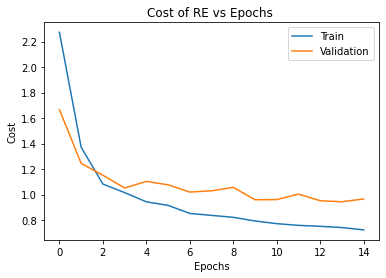

In [ ]:
plt.plot(train_losses3)
plt.plot(validation_losses3)
plt.title("Cost of RE vs Epochs ")
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

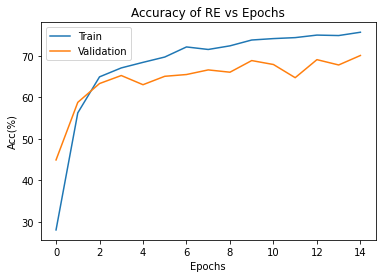

In [ ]:
plt.plot(train_accs3)
plt.plot(val_accs3)
plt.title("Accuracy of RE vs Epochs")
plt.ylabel('Acc(%)')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

In [ ]:
PATH = '/content/drive/My Drive/RelationClassification3.pth'
torch.save(model3.state_dict(), PATH)

In [ ]:
print(train_losses3)

[2.2730218744277955, 1.371381072998047, 1.082924234867096, 1.0161281967163085, 0.9434240913391113, 0.9155745148658753, 0.852635338306427, 0.8371693634986878, 0.8220522952079773, 0.7934058737754822, 0.7723536467552186, 0.7589368867874146, 0.7515357494354248, 0.7417515540122985, 0.7233498883247376]


In [ ]:
print(validation_losses3)

[1.6664947271347046, 1.2449647188186646, 1.1519047419230144, 1.0524000525474548, 1.1035292148590088, 1.076818585395813, 1.0200554927190144, 1.0300426681836445, 1.0569194555282593, 0.9597272475560507, 0.9611027042071024, 1.004289150238037, 0.9520680904388428, 0.9441318511962891, 0.9662835796674093]


In [ ]:
print(train_accs3)

[tensor(28.0235, device='cuda:0'), tensor(56.2753, device='cuda:0'), tensor(64.9631, device='cuda:0'), tensor(67.1196, device='cuda:0'), tensor(68.4634, device='cuda:0'), tensor(69.7459, device='cuda:0'), tensor(72.1832, device='cuda:0'), tensor(71.5734, device='cuda:0'), tensor(72.4486, device='cuda:0'), tensor(73.8551, device='cuda:0'), tensor(74.1985, device='cuda:0'), tensor(74.4329, device='cuda:0'), tensor(75.0437, device='cuda:0'), tensor(74.9342, device='cuda:0'), tensor(75.7307, device='cuda:0')]


In [ ]:
print(val_accs3)

[tensor(44.9114, device='cuda:0'), tensor(58.8090, device='cuda:0'), tensor(63.3493, device='cuda:0'), tensor(65.2841, device='cuda:0'), tensor(63.0686, device='cuda:0'), tensor(65.0976, device='cuda:0'), tensor(65.5262, device='cuda:0'), tensor(66.6412, device='cuda:0'), tensor(66.0843, device='cuda:0'), tensor(68.8926, device='cuda:0'), tensor(67.9439, device='cuda:0'), tensor(64.7633, device='cuda:0'), tensor(69.1171, device='cuda:0'), tensor(67.8327, device='cuda:0'), tensor(70.1208, device='cuda:0')]


### Test Network

In [ ]:
int_2_cat_class = dict(enumerate(train_df['label'].cat.categories))

# Hyperparameters
embedding_size = 300
hidden_size = 150
vocab_size = len(vocab_df)
num_layers = 2
class_num = len(int_2_cat_class)

int_2_cat_class = dict(enumerate(test_df['label'].cat.categories))

# Training and validation Data Generators
test_set = SemEval2010_task8_Dataset2(test_df,partition['test'],vocab)

pad_idx = vocab_df.str_2_idx["<pad>"]

# Parameters
params = {'batch_size': 2717,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate2(pad_idx=pad_idx)
          }

test_generator = torch.utils.data.DataLoader(test_set, **params)

PATH = '/content/drive/My Drive/RelationClassification3.pth'

# Model
# model3 = RelationClassification_Model2(embedding_size, hidden_size, vocab_size, num_layers,class_num,embedding,pad_idx).to(device)
# model3.load_state_dict(torch.load(PATH))

with torch.set_grad_enabled(False):
    for batch_data, batch_labels,mask_e1,mask_e2 in tqdm(test_generator):
        # Transfer to GPU
        batch_data, batch_labels,mask_e1,mask_e2 = batch_data.to(device), batch_labels.to(device),mask_e1.to(device),mask_e2.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model3(batch_data,mask_e1,mask_e2)        

        y_test3 = np.argmax(batch_outputs.cpu().numpy(),axis = 1)
        y_predictions3 = batch_labels.cpu().numpy()

        precision_metric3 = precision_score(y_test3, y_predictions3, average = "macro")

        recall_metric3 = recall_score(y_test3, y_predictions3, average = "macro")

        accuracy_metric3 = accuracy_score(y_test3, y_predictions3)

        f1_metric3 = f1_score(y_test3, y_predictions3, average = "macro")



  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


In [ ]:
precision_metric3,recall_metric3,accuracy_metric3 ,f1_metric3

(0.6594247172845241, 0.6563515674651444, 0.694147957305852, 0.6508454968405486)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.81      0.84      0.82       134
           1       0.85      0.84      0.84       194
           2       0.83      0.69      0.75       162
           3       0.61      0.59      0.60       150
           4       0.82      0.80      0.81       153
           5       0.87      0.67      0.75        39
           6       0.87      0.78      0.82       291
           7       0.00      0.00      0.00         1
           8       0.63      0.90      0.74       211
           9       0.85      0.74      0.80        47
          10       0.75      0.14      0.23        22
          11       0.73      0.44      0.55       134
          12       0.37      0.31      0.34        32
          13       0.71      0.93      0.80       201
          14       0.75      0.63      0.68       210
          15       0.79      0.37      0.51        51
          16       0.47      0.30      0.36       454
          17       0.36    

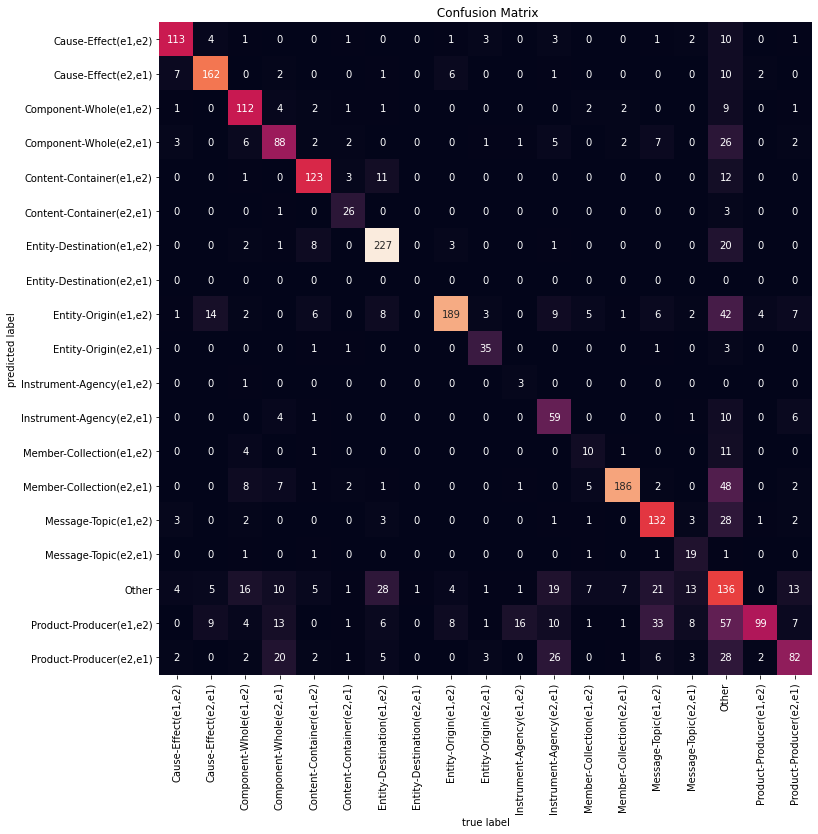

In [ ]:
import seaborn as sns 
print(classification_report(y_test2, y_predictions2)) 

labels = list(int_2_cat_class.values())
f, ax = plt.subplots(figsize=(16, 12))
cnf_matrix = confusion_matrix(y_test2, y_predictions2)
ax = sns.heatmap(cnf_matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels , yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(' Confusion Matrix')
plt.show()
